<b style="font-size: 1.2em;">
    <span style="color: #CA1821;">Insper</span>
    <br/>
    prof. Fábio Pelicano Vieira
</b>
<br/>
<b>Modelagem e Simulação do mundo físico</b>
<br/>
<br/>
<b style>Projeto #2</b>
<br/>
<b style="font-size: 1.4em;">Termodinânima de uma xícara de chá</b>
<br/>
<br/>
<b>Guilherme da Franca Silva Escobar</b>
<br/>
<b>Luciano Felix Dias</b>
<br/>
<b>Rodrigo Paoliello de Medeiros</b>


## Introdução
Intrudução ao projeto...

**Figura 1  - Diagrama de Estoques e Fluxos**

<img src="fluxograma.svg" width=600 style="float: left;"/>


In [13]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [37]:
# Coeficientes de Condutividade Térmica (em W/(m² * K))
K_amb = 0.58
K_ceramica = 1.05

# Calores Específicos (em J/(kg * K))
C_agua = 4180
C_ceramica = 1070

# Densidades (em kg/m³)
D_ceramica = 2403
D_agua = 1000

# Tempratura Ambiente (em K)
T_amb = 293.15

# Coeficiente Convectivo do Ar
h_ar = 10

# Dimensões do Recipiente (em m)
l = 0.005                    # Espessura
h = 0.09                     # Altura
r = 0.04                     # Raio
h_int = h - l                # Altura interna
r_int = r - l                # Raio interno
Sb_ext = math.pi * r**2      # área da base externa
Sb_int = math.pi * r_int**2  # área da base interna

# Áreas (em m²)
Sl_ext = (2 * math.pi * r) * h          # área lateral externa
Sl_int = (2 * math.pi * r_int) * h_int  # área lateral interna
S_ext  = Sb_ext + Sl_ext                # Área externa
S_int  = Sb_int + Sl_int                # Área interna
S_mid  = (S_ext + S_int) / 2            # Área intermediária

# Volumes (em m³)
v_agua = Sb_int * h_int
v_xicara = (Sb_ext * h) - v_agua

# Massas (em kg)
m_xicara = v_xicara * D_ceramica
m_agua = v_agua * D_agua

# Resistências térmicas
Rconv_1 = 1 / (h_ar * S_int)
Rcond_1 = (l/2) / (K_ceramica * S_int)
Rcond_2 = (l/2) / (K_ceramica * S_mid)
Rconv_2 = 1 / (h_ar * S_ext)


In [15]:
def modelo (T,t):
    T_agua, T_xicara = T
    
    Q1 = (T_agua - T_amb) / Rconv_1
    Q2 = (T_agua - T_xicara) / Rcond_1
    Q3 = (T_xicara - T_amb) / (Rcond_2 + Rconv_2)
    
    dUadt = - Q1 - Q2
    dUrdt = Q2 - Q3
    
    dTadt = dUadt / (m_agua * C_agua)
    dTrdt = dUrdt / (m_xicara * C_ceramica)
    
    dxdt = (dTadt, dTrdt)
    
    return dxdt


In [79]:
# Tempo (em min)
dt = 1e-8
t_max = 3
tempo = np.arange(0, t_max, dt)

# Temperaturas Iniciais (em K)
T0_agua = 353.15
T0_xicara = 298.15
T0 = (T0_agua, T0_xicara)

# Implementação do modelo
T_list = odeint(modelo, T0, tempo)
T_agua = T_list[:,0] - 273.15
T_xicara = T_list[:,1] - 273.15

# Plotagem do gráfico
plt.plot(tempo, T_agua, label='Água')
plt.plot(tempo, T_xicara, label='Xícara')
plt.title('Série temporal teperatura da Água e da Xícara')
plt.xlabel('Tempo (min)')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()
plt.savefig('temperatura.png')


MemoryError: Unable to allocate 2.24 GiB for an array with shape (299999999,) and data type float64

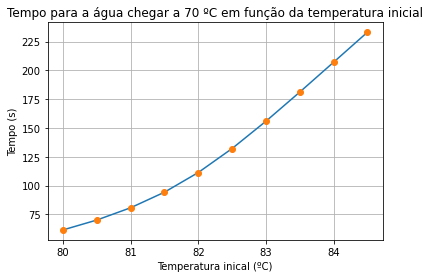

<Figure size 432x288 with 0 Axes>

In [74]:
# Temperaturas Iniciais (em K)
lista_T0_agua = np.arange(353.15, 358.15, 0.5)

# Implementação do modelo
lista_tempos = []

for T0_agua in lista_T0_agua:
    T0 = (T0_agua, T0_xicara)
    
    T_list = odeint(modelo, T0, tempo)
    T_agua_list = T_list[:,0]
    
    for i, T in enumerate(T_agua_list):
        if T <= 70 + 273.15:
            instante = tempo[i]
            
            lista_tempos.append(instante)
            break
            
# Plotagem do gráfico
plt.plot(lista_T0_agua-273.15, lista_tempos)
plt.plot(lista_T0_agua-273.15, lista_tempos, 'o')
plt.title('Tempo para a água chegar a 70 ºC em função da temperatura inicial')
plt.ylabel('Tempo (s)')
plt.xlabel('Temperatura inical (ºC)')
plt.grid()
plt.show()
plt.savefig('tempo_xicara.png')


In [71]:
def modelo_2 (T, t, xicara):
    K_xicara, C_xicara, d_xicara, l_xicara = xicara
    
    h_int = h - l_xicara         # Altura interna
    r_int = r - l_xicara         # Raio interno
    Sb_int = math.pi * r_int**2  # área da base interna

    # Áreas (em m²)
    Sl_int = (2 * math.pi * r_int) * h_int  # área lateral interna
    S_int  = Sb_int + Sl_int                # Área interna
    S_mid  = (S_ext + S_int) / 2            # Área intermediária

    # Volumes (em m³)
    v_agua = Sb_int * h_int
    v_xicara = (Sb_ext * h) - v_agua

    # Massas (em kg)
    m_xicara = v_xicara * d_xicara

    # Resistências térmicas
    Rconv_1 = 1 / (h_ar * S_int)
    Rcond_1 = (l_xicara/2) / (K_xicara * S_int)
    Rcond_2 = (l_xicara/2) / (K_xicara * S_mid)
    Rconv_2 = 1 / (h_ar * S_ext)
    
    T_agua, T_xicara = T
    
    Q1 = (T_agua - T_amb) / Rconv_1
    Q2 = (T_agua - T_xicara) / Rcond_1
    Q3 = (T_xicara - T_amb) / (Rcond_2 + Rconv_2)
    
    dUadt = - Q1 - Q2
    dUrdt = Q2 - Q3
    
    dTadt = dUadt / (m_agua * C_agua)
    dTrdt = dUrdt / (m_xicara * C_xicara)
    
    dxdt = [dTadt, dTrdt]
    
    return dxdt


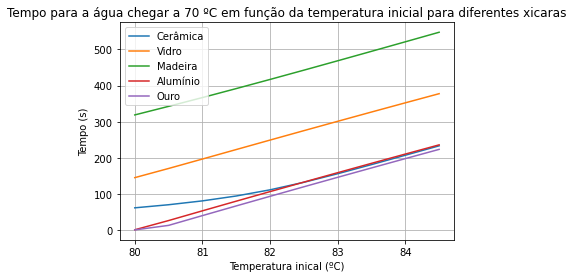

In [76]:
# Tempo (em s)
dt = 1e-2
t_max = 700
tempo = np.arange(0, t_max, dt)

materiais = ("Cerâmica", "Vidro", "Madeira", "Alumínio", "Ouro")
K_xicara_list = (K_ceramica, 0.8, 0.14, 235, 327)
C_xicara_list = (C_ceramica, 870, 2530, 900, 129)
D_xicara_list = (D_ceramica, 2190, 690, 2700, 19300)
l_xicara_list = (l, l, l, l, l, l)

xicaras = zip(K_xicara_list, C_xicara_list, D_xicara_list, l_xicara_list)

# Implementação do modelo
xicaras_tempos = []

for xicara in xicaras:
    xicara_tempos = []
    
    for T0_agua in lista_T0_agua:
        T0 = (T0_agua, T0_xicara)

        T_list = odeint(modelo_2, T0, tempo, args=(xicara, ))
        T_agua_list = T_list[:,0] - 273.15

        for i, T in enumerate(T_agua_list):
            if T <= 70:
                instante = tempo[i]

                xicara_tempos.append(instante)
                break

    xicaras_tempos.append(xicara_tempos)

# Plotagem do gráfico
for i, material in enumerate(materiais):
    xicara_tempos = xicaras_tempos[i]
    
    plt.plot(lista_T0_agua-273.15, xicara_tempos, label=material)
    
plt.title('Tempo para a água chegar a 70 ºC em função da temperatura inicial para diferentes xicaras')
plt.ylabel('Tempo (s)')
plt.xlabel('Temperatura inical (ºC)')
plt.legend()
plt.grid()
plt.savefig('tempos_xicaras.png')
plt.show()
